In [1]:
from os.path import join, dirname, abspath
import sys
CURRENT_DIR = os.getcwd()
sys.path.insert(0, join(CURRENT_DIR, '../..'))  # Import local models

In [2]:
from models.PickModel import PickModel
from models.PlaceModel import PlaceModel
from cliport.dataset import RavensDataset
import torch
from src.scripts.utils import get_affordance_map_from_formatted_input
import matplotlib.pyplot as plt
import numpy as np

pybullet build time: Sep 22 2020 00:56:01


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [20]:
pick_model = PickModel(num_rotations=1, batchnorm = False).to('cuda')

In [ ]:
pick_model.load_state_dict(torch.load("/home/ubuntu/VLM/checkpoint/checkpoint_model_best_place.pth")['state_dict'])

In [4]:
place_model = PlaceModel(num_rotations=12, crop_size=64, batchnorm = False).to('cuda')

In [28]:
place_model.load_state_dict(torch.load("/home/ubuntu/VLM/checkpoint/checkpoint_model_best_place.pth")['state_dict'])

<All keys matched successfully>

In [7]:
train_dataset_cfg = {"dataset":{"type": "single",
                    "images": True,
                    "cache": False,
                    "augment":{"theta_sigma":60},
                    "cache_size": 350},
                    }

# load data
train_dataset = RavensDataset('/home/ubuntu/cliport/data/stack-block-pyramid-seq-seen-colors-val', train_dataset_cfg, n_demos=100, augment=False)

In [8]:
batch_data = next(iter(train_dataset))
inp, _ = batch_data

In [9]:
inp['lang_goal']

'put the brown block on the green and cyan blocks'

In [147]:
inp['lang_goal'] = "put the left block on the red block"

In [148]:
def run_pick():
    pick_model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        p0 = inp['p0']
        yaw_deg = inp['p0_theta']
        output_size = (
            1, 320, 160)

        pick_demonstration = get_affordance_map_from_formatted_input(x=p0[0], y=p0[1], rotation_deg=yaw_deg, output_size=output_size)
        device = 'cuda'
        img_cuda = torch.Tensor(inp['img']).to(device)
        language_cuda = inp['lang_goal']

        affordances = pick_model(img_cuda, language_cuda)
        pick_model(img_cuda, language_cuda)
        affordances = affordances.view(affordances.shape[0], -1)
        pick_demonstration = torch.unsqueeze(pick_demonstration, dim=0).to(device)
        pick_demonstration = pick_demonstration.view(pick_demonstration.shape[0], -1)
        loss = loss_fn(affordances, pick_demonstration)
        
        preds = torch.nn.functional.softmax(affordances, dim=1)
        preds = preds.cpu()
        preds = preds.view(320,160)
        location = np.unravel_index(torch.argmax(preds).numpy(), (320,160))
    
    return loss, preds, location


In [12]:
def run_place():
    place_model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        p0 = inp['p0']
        p1 = inp['p1']
        p1_deg = inp['p1_theta']
        output_size = (12, 320, 160)

        place_demonstration = get_affordance_map_from_formatted_input(x=p1[0], y=p1[1], rotation_deg=p1_deg, output_size=output_size)
        device = 'cuda' # TODO: Not do this
        img_cuda = torch.Tensor(inp['img']).to(device)
        language_cuda = inp['lang_goal']#.to(device)

        affordances = place_model(img_cuda, language_cuda, p0)
        affordances = affordances.view(affordances.shape[0], -1)
        place_demonstration = torch.unsqueeze(place_demonstration, dim=0).to(device)
        place_demonstration = place_demonstration.view(place_demonstration.shape[0], -1)
        loss = loss_fn(affordances, place_demonstration)

        preds = torch.nn.functional.softmax(affordances, dim=1)
        preds = preds.cpu()
        preds = preds.view(12, 320,160)
        location = np.unravel_index(torch.argmax(preds).numpy(), (12, 320,160))        
        
    return loss, preds, location


In [13]:
loss, preds, location = run_place()        

In [16]:
location

(7, 47, 68)

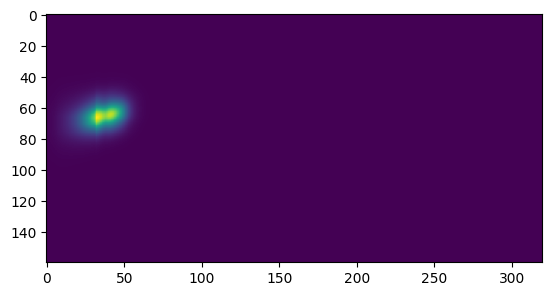

In [20]:
channel = 2
plt.imshow(preds[channel].T/preds[channel].max())

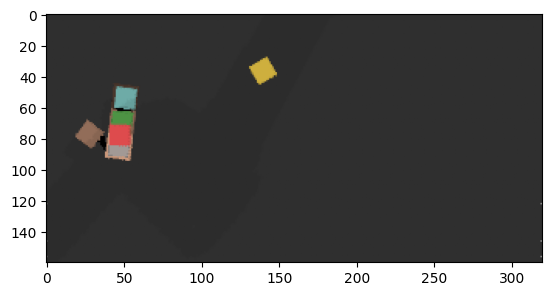

In [21]:
plt.imshow(inp['img'][:,:,0:3].transpose((1,0,2))/255)

In [22]:
import wandb

In [23]:
wandb.init(project="11785-Final-Project", entity="11785-vlm", name="model", resume = "must", id="hhyzevc5")

E1206 02:44:13.724067 139655815342976 jupyter.py:99] Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: kgmelin (use `wandb login --relogin` to force relogin)
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
wandb.save("/home/ubuntu/VLM/checkpoint/checkpoint_model_best.pth")

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/home/ubuntu/VLM/src/scripts/wandb/run-20221206_024413-hhyzevc5/files/checkpoint_model_best.pth']

In [25]:
wandb.finish()

train_attention_loss,9.0376
lr,0.0001
_step,659
_runtime,89654
_timestamp,1670292703
val_total_loss,14.23604
train_total_loss,9.0376
val_attention_loss,14.23604


In [29]:
api = wandb.Api()

run1 = api.run("11785-vlm/11785-Final-Project/2t79bsv5")
run1.file("checkpoint_model_best.pth").download(root="./pick_model", replace=True)

<_io.TextIOWrapper name='./pick_model/checkpoint_model_best.pth' mode='r' encoding='UTF-8'>